In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import bioframe

In [2]:
os.chdir("/path/")

In [3]:
screen = pd.read_csv("mESC_contact_screen_result.txt", sep="\t")

In [4]:
screen.head()

,ID_Factor,p_value_short,F_value_short,adj_p_short,Factor,p_value_long,F_value_long,adj_p_long,Group
0,GSE80280_CTCF,5.603132e-67,0.514695,63.576708,CTCF,2.262945e-295,0.511645,291.970465,Cohesin
1,GSE90994_RAD21,0.000000e+00,0.532221,inf,RAD21,2.450876e-87,0.505209,83.935817,Cohesin
2,GSE125129_RAD21,0.000000e+00,0.531510,inf,RAD21,3.494969e-154,0.507011,150.781696,Cohesin
3,GSE90994_CTCF,1.418955e-98,0.517277,95.173170,CTCF,0.000000e+00,0.512813,inf,Cohesin
4,GSE126362_CTCF,5.159081e-251,0.527517,247.612567,CTCF,0.000000e+00,0.520070,inf,Cohesin


In [5]:
TSS_noRING1B = pd.read_csv("mm10.refGene_exon1_TSS_noRING1B.bed", 
                           sep="\t", header=None, usecols=[0,1,2])
TSS_noRING1B.columns = ["chrom", "start", "end"]

In [6]:
cistrome_remap = pd.read_csv("mm10-cCREs_ESC_DNase_merged5kb_mm10_cistromeDB_ReMap2020_filtered.bed", 
                             sep="\t", 
                             dtype={"chrom_cres": str, "start_cres": int, 
                                    "end_cres": int, "ID": str})

In [7]:
ids = cistrome_remap["ID_Factor"].unique()

In [8]:
TSS_noRING1B_overlap = {"ID_Factor": [], "TSS_noRING1B_Overlap": []}
i = 1
counter = 0
for id in ids:
    percent = (i / len(ids))*100
    i += 1
    if (percent>counter) & (np.floor(percent)%10 == 0):
        print(str(np.floor(percent))+"% finished")
        counter += 10
    regions = cistrome_remap.loc[cistrome_remap["ID_Factor"] == id, 
                                 ["chrom_cres", "start_cres", "end_cres"]]
    overlap = bioframe.overlap(regions, TSS_noRING1B, 
                               cols1=["chrom_cres", "start_cres", "end_cres"],
                               how="both")
    TSS_noRING1B_overlap['ID_Factor'].append(id)
    TSS_noRING1B_overlap['TSS_noRING1B_Overlap'].append(overlap.shape[0]/regions.shape[0])
print("100.0% finished")
TSS_noRING1B_overlap = pd.DataFrame(TSS_noRING1B_overlap)

0.0% finished
10.0% finished
20.0% finished
30.0% finished
40.0% finished
50.0% finished
60.0% finished
70.0% finished
80.0% finished
90.0% finished
100.0% finished


In [9]:
merge = pd.merge(screen, TSS_noRING1B_overlap, on="ID_Factor")

In [10]:
melt = pd.melt(merge, value_vars=["F_value_long", "F_value_short"], 
               id_vars=["Group", "ID_Factor", "TSS_noRING1B_Overlap"])

In [11]:
palette = {f:'whitesmoke' for f in set(melt["Group"])}
for f in melt.loc[melt["Group"] == "TF","Group"]:
    palette[f] = '#4daf4a' 
for f in melt.loc[melt["Group"] == "Co-factors","Group"]:
    palette[f] = '#e41a1c' 
for f in melt.loc[melt["Group"] == "Cohesin","Group"]:
    palette[f] = 'orange'
for f in melt.loc[melt["Group"] == "Polycomb","Group"]:
    palette[f] = '#377eb8'
for f in melt.loc[melt["Group"] == "Repressive","Group"]:
    palette[f] = 'cyan'

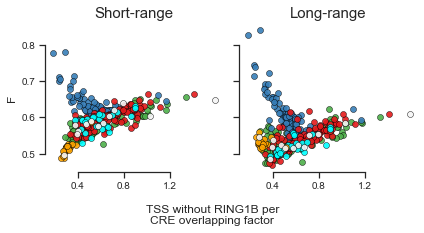

In [12]:
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":12, "xtick.labelsize": 10,
                                "ytick.labelsize": 10})  
g = sns.FacetGrid(data=melt.sample(melt.shape[0], random_state=100), 
                  col="variable", hue="Group", palette=palette)
g.map(sns.scatterplot, "TSS_noRING1B_Overlap", "value", alpha = 0.9, edgecolor="black")
g.set(xlabel="", 
      ylabel="F",
      xticks=[0.4, 0.8, 1.2])
g.fig.text(0.5, 0, "TSS without RING1B per\nCRE overlapping factor", 
          horizontalalignment='center',
          verticalalignment='center',
          fontsize=12)
sns.despine(trim=True)
axes = g.axes.flatten()
axes[0].set_title("Short-range")
axes[1].set_title("Long-range")
g.savefig("plots/corr_TSS_noRING1B_screen.svg")